# DL2Vec

In [1]:
import sys
sys.path.append("../../../")

import torch as th
#import logging


import pickle as pkl
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)

In [11]:
from mowl.datasets.ppi_yeast import PPIYeastSlimDataset
from mowl.graph.dl2vec.model import DL2VecParser
from mowl.graph.factory import parser_factory
from mowl.walking.factory import walking_factory

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence


## DL2Vec

## DL2Vec with Deepwalk

In [12]:
dataset = PPIYeastSlimDataset()

#parser = DL2VecParser(dataset.ontology, bidirectional_taxonomy = True)
parser = parser_factory("dl2vec", dataset.ontology, bidirectional_taxonomy = True)
edges = parser.parse()

walker = walking_factory("deepwalk", edges, alpha = 0.1, walk_length = 10, num_walks = 10, outfile = "data/walks")
walker.walk()

corpus = LineSentence("data/walks")

w2v_model = Word2Vec(
        corpus,
        sg=1,
        min_count=1,
        vector_size=10,
        window = 10,
        epochs = 10,
        workers = 16)

vectors = w2v_model.wv

INFO: Number of ontology classes: 11020
Starting pool...+ started processing 0


INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 45083 words, keeping 10632 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 90137 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 135781 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 181090 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 225721 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 271068 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 316618 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #80000, processed 362180 words, keeping 110

- finished processing 0 after 704
* processing is over, shutting down the executor


INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 500082 word corpus (100.0%% of original 500082, drops 0)', 'datetime': '2022-04-25T23:49:56.890428', 'gensim': '4.1.2', 'python': '3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-109-generic-x86_64-with-glibc2.27', 'event': 'prepare_vocab'}
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 11020 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 11 most-common words
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'downsampling leaves estimated 471063.1107809666 word corpus (94.2%% of prior 500082)', 'datetime': '2022-04-25T23:49:56.926235', 'gensim': '4.1.2', 'python': '3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-109-generic-x86_64-with-glibc2.27', 'event': 'prepare_vocab'}
INFO:gensim.models.word2vec:estimated required memory for 11020 words and 10 dimensions: 

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; 

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 10 : training on 500082 raw words (471033 effective words) took 0.6s, 736076 effective words/s
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'training on 5000820 raw words (4710183 effective words) took 6.2s, 756183 effective words/s', 'datetime': '2022-04-25T23:50:03.222970', 'gensim': '4.1.2', 'python': '3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-109-generic-x86_64-with-glibc2.27', 'event': 'train'}
INFO:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec(vocab=11020, vector_size=10, alpha=0.025)', 'datetime': '2022-04-25T23:50:03.223656

In [3]:
model.train()

INFO:root:Generating graph from ontology...


INFO: Number of ontology classes: 11020


INFO:root:Finished graph generation
INFO:root:Generating random walks...


Starting pool...+ started processing 1
+ started processing 5
+ started processing 6
+ started processing 8
+ started processing 3
+ started processing 2
+ started processing 7
+ started processing 0
+ started processing 4
+ started processing 9
+ started processing 10
+ started processing 11
+ started processing 12
+ started processing 13
+ started processing 14
+ started processing 15


INFO:root:Walks generated
INFO:root:Walks saved at data/dl2vec_walks
INFO:root:Starting to train the Word2Vec model
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 98930 words, keeping 7253 word types


- finished processing 3 after 1590
- finished processing 4 after 1628
- finished processing 10 after 1627
- finished processing 1 after 1629
- finished processing 9 after 1634
- finished processing 13 after 1635
- finished processing 2 after 1643
- finished processing 11 after 1643
- finished processing 8 after 1648
- finished processing 0 after 1649
- finished processing 7 after 1652
- finished processing 5 after 1661
- finished processing 6 after 1663
- finished processing 12 after 1666
- finished processing 14 after 1721
- finished processing 15 after 1733
* processing is over, shutting down the executor


INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 194688 words, keeping 8749 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 296526 words, keeping 9489 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 395582 words, keeping 9932 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 493497 words, keeping 10243 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 593344 words, keeping 10435 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 688885 words, keeping 10590 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #80000, processed 786199 words, keeping 10713 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #90000, processed 883553 words, keeping 10809 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #100000, processed 986501 words, keeping 10861 word types
INFO:gensim.models.word2vec:PROGRESS: a

INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 13.45% examples, 625615 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 27.58% examples, 639079 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 43.02% examples, 670662 words/s, in_qsize 0, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 56.71% examples, 664583 words/s, in_qsize 0, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 71.98% examples, 668852 words/s, in_qsize 0, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 1 - PROGRESS: at 87.61% examples, 678119 words/s, in_qsize 2, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 4 : training on 5476013 raw words (4753154 effective words) took 7.0s, 677459 effective words/s
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 10.28% examples, 477242 words/s, in_qsize 28, out_qsize 3
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 23.70% examples, 555236 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 39.89% examples, 623009 words/s, in_qsize 27, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 5 - PROGRESS: at 53.55% examples, 629309 words/s, in_qsize 30, out_qsize 0
IN

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 8 : training on 5

INFO:gensim.models.word2vec:EPOCH 12 - PROGRESS: at 85.43% examples, 662917 words/s, in_qsize 29, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2

INFO:gensim.models.word2vec:EPOCH 16 - PROGRESS: at 9.92% examples, 466073 words/s, in_qsize 24, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 16 - PROGRESS: at 25.58% examples, 594624 words/s, in_qsize 30, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 16 - PROGRESS: at 39.53% examples, 617787 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 16 - PROGRESS: at 55.25% examples, 634193 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 16 - PROGRESS: at 70.88% examples, 654787 words/s, in_qsize 27, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 16 - PROGRESS: at 83.22% examples, 644057 words/s, in_qsize 29, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more t

KeyboardInterrupt: 

In [9]:
word2VecModel = Word2Vec.load("data/dl2vec_deepwalk")

INFO:gensim.utils:loading Word2Vec object from data/dl2vec_deepwalk
INFO:gensim.utils:loading wv recursively from data/dl2vec_deepwalk.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:Word2Vec lifecycle event {'fname': 'data/dl2vec_deepwalk', 'datetime': '2022-03-09T14:37:22.166287', 'gensim': '4.1.2', 'python': '3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-100-generic-x86_64-with-glibc2.27', 'event': 'loaded'}


In [10]:
vectors = word2VecModel.wv
type(vectors)
#print(vectors.index_to_key)

gensim.models.keyedvectors.KeyedVectors

In [11]:
dl2vec_deepwalk_embeddings = {}
for node in model.entities:
    if node.startswith("4932"):
        dl2vec_deepwalk_embeddings[node] = vectors[node]
        
with open("data/dl2vec_embeddings_deepwalk", "wb") as file:
    pkl.dump(dl2vec_deepwalk_embeddings, file)

NameError: name 'model' is not defined

## Evaluation

In [12]:
from mowl.graph.dl2vec.model import DL2VecParser
ds = PPIYeastSlimDataset()
train_parser = DL2VecParser(ds.ontology, bidirectional_taxonomy = True)
test_parser = DL2VecParser(ds.testing, bidirectional_taxonomy = True)

train_set = train_parser.parse()
#train_set = [x.astuple() for x in train_set]

test_set = test_parser.parse()
#test_set = [x.astuple() for x in test_set]

INFO: Number of ontology classes: 11020
INFO: Number of ontology classes: 3610


In [13]:
from mowl.graph.edge import Edge
train_ents,_ = Edge.getEntitiesAndRelations(train_set)
test_ents,_ = Edge.getEntitiesAndRelations(test_set)
toRemove = "4932.YNL150W"
test_set = [e for e in test_set if (e.src() != toRemove and e.dst() != toRemove)]

In [14]:
 set(test_ents) - set(train_ents)

{'4932.YNL150W'}

In [15]:
from mowl.evaluation.evaluator import PPIEvaluator

embeddings = pkl.load(open("data/dl2vec_embeddings_deepwalk", "rb"))
#print(list(embeddings.items())[0])
bevaluator = PPIEvaluator(embeddings, train_set, test_set)



In [16]:
evaluator.evaluate(show = True)

Proteins dictionary created. Number of proteins: 6034
Training labels created

Hits@1:   0.00 Filtered: 0.00
Hits@10:  0.03 Filtered: 0.04
Hits@100: 0.32 Filtered: 0.45
MR@10:    419.13 Filtered: 352.10
AUC@10:   0.93 Filtered: 0.94
Evaluation finished. Access the results using the "metrics" attribute.


In [10]:
evaluator.metrics

{'hits_1': 0.0,
 'hits_10': 0.031898986542615054,
 'hits_100': 0.32995514205017445,
 'mean_rank': 429.8692473832863,
 'rank_auc': 0.9288572012018289,
 'fhits_1': 0.0,
 'fhits_10': 0.005897989699285596,
 'fhits_100': 0.23093537132414022,
 'fmean_rank': 471.1685495929556,
 'frank_auc': 0.9220168030217867}

In [17]:
evaluator.metrics

{'hits_1': 0.0,
 'hits_10': 0.0,
 'hits_100': 0.0003322811098189068,
 'mean_rank': 5605.130752616714,
 'rank_auc': 0.0711744319983735,
 'fhits_1': 0.0,
 'fhits_10': 0.0,
 'fhits_100': 0.0003322811098189068,
 'fmean_rank': 5563.831450407044,
 'frank_auc': 0.07802217833230898}

In [19]:
evaluator.metrics

{'hits_1': 0.0,
 'hits_10': 0.0,
 'hits_100': 0.0001661405549094534,
 'mean_rank': 5689.980727695631,
 'rank_auc': 0.05710433147755563,
 'fhits_1': 0.0,
 'fhits_10': 0.0,
 'fhits_100': 0.0001661405549094534,
 'fmean_rank': 5645.358199036385,
 'frank_auc': 0.06450505822821699}

## TSNE

In [8]:
ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = '{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]

In [9]:
ec_dict = {}
for prot in ec_numbers:
    if prot in dl2vec_deepwalk_embeddings:
        ec_dict[prot] = dl2vec_deepwalk_embeddings[prot]
        
size = model.vector_size
embeds = np.zeros((len(ec_dict), size), dtype=np.float32)

for i, emb in enumerate(ec_dict.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(ec_dict.keys()):
    nodemap[i] = m
    

X = TSNE(n_components=2, verbose=1, n_iter=5000, n_jobs=8).fit_transform(embeds)

/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1712 samples in 0.001s...
[t-SNE] Computed neighbors for 1712 samples in 0.378s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1712
[t-SNE] Computed conditional probabilities for sample 1712 / 1712
[t-SNE] Mean sigma: 1.434203
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.749382
[t-SNE] KL divergence after 5000 iterations: 1.117244


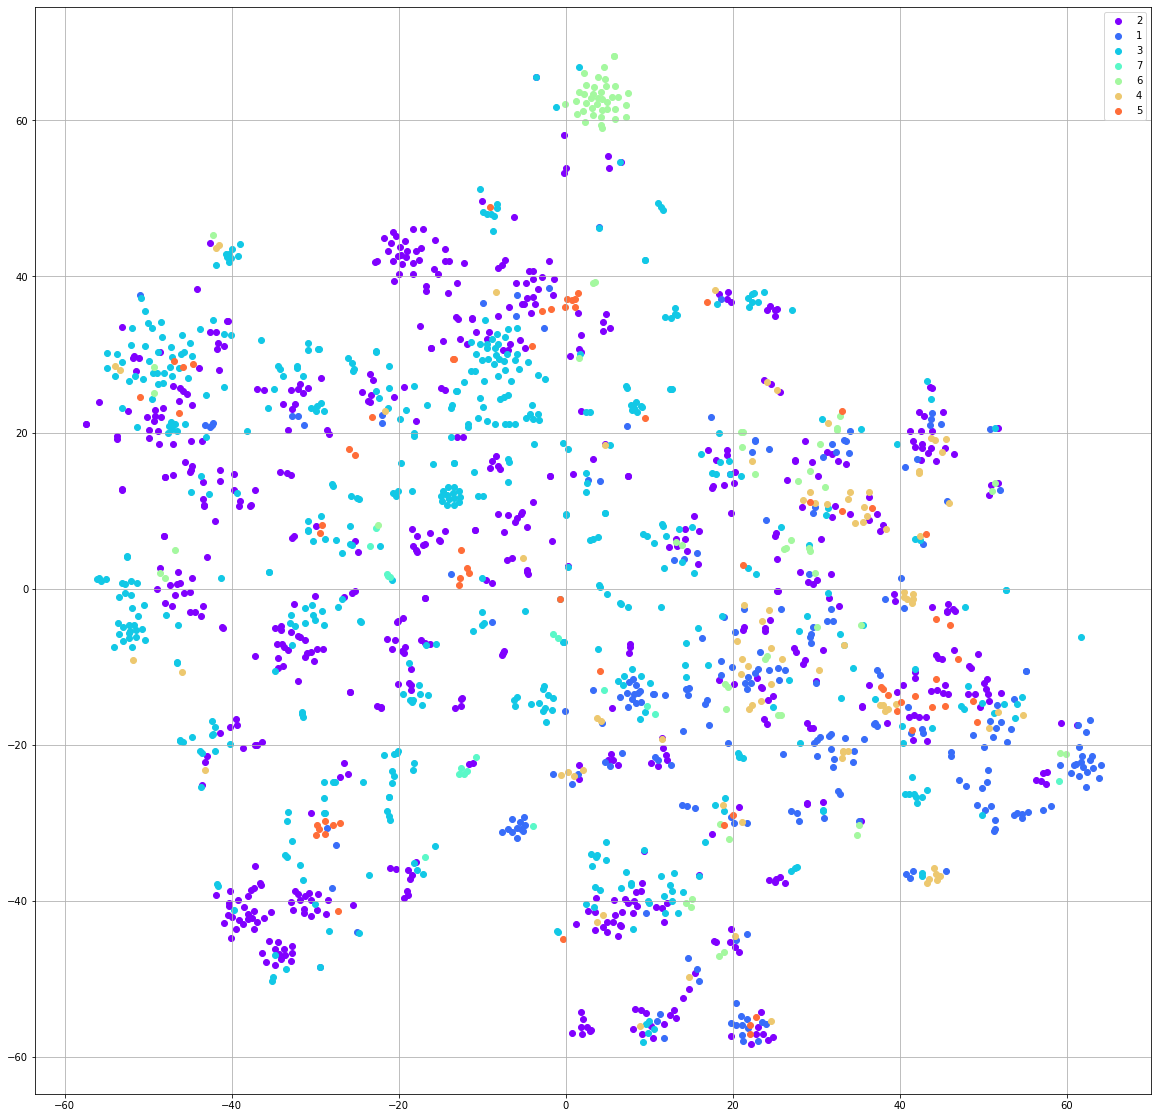

In [10]:
classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[k, 0])
        classes[ec][1].append(X[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)
plt.savefig('data/fig_dl2vec_deepwalk.jpg')
plt.show()

## DL2Vec with Node2Vec

In [12]:
dataset = PPIYeastSlimDataset()
    
model = DL2Vec(
    dataset, 
    "data/dl2vec_node2vec", 
    bidirectional_taxonomy=True,
    walking_method = "node2vec",
    walk_length=50, 
    vector_size = 100,
    num_walks=100,
    wv_epochs = 10,
    p = 10,
    q = 0.1,
    window=5,
    workers = 16
)

In [13]:
model.train()

INFO:root:Generating graph from ontology...


INFO: Number of ontology classes: 11020


INFO:root:Finished graph generation
INFO:root:Generating random walks...


Starting pool...+ started preprocessing probabilities...
Thread 0, nodes to process 368
Thread 1, nodes to process 379
Thread 2, nodes to process 393
Thread 3, nodes to process 387
Thread 4, nodes to process 375
Thread 5, nodes to process 382
Thread 6, nodes to process 391
Thread 7, nodes to process 390
Thread 8, nodes to process 400
Thread 9, nodes to process 390
Thread 10, nodes to process 362
Thread 11, nodes to process 402
Thread 12, nodes to process 411
Thread 14, nodes to process 386
Thread 13, nodes to process 393
Thread 15, nodes to process 389
* processing nodes is over
Thread 0, edges to process 15574
Thread 7, edges to process 15574
Thread 6, edges to process 15574
Thread 3, edges to process 15574
Thread 1, edges to process 15574
Thread 12, edges to process 15573
Thread 2, edges to process 15574
Thread 10, edges to process 15574
Thread 4, edges to process 15574
Thread 11, edges to process 15573
Thread 14, edges to process 15573
Thread 13, edges to process 15573
Thread 8, edg

INFO:root:Walks generated
INFO:root:Starting to train the Word2Vec model
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 42929 words, keeping 6850 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 88203 words, keeping 8310 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 133508 words, keeping 9114 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 176751 words, keeping 9558 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 222741 words, keeping 9934 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 269292 words, keeping 10192 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #70000, processed 314568 words, keeping 10386 word types
INFO:gensim.models.word2v

- finished processing 12 after 3292
- finished processing 14 after 3293
- finished processing 15 after 3296
- finished processing 13 after 3320
* processing is over, shutting down the executor


INFO:gensim.models.word2vec:PROGRESS: at sentence #110000, processed 505376 words, keeping 10799 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #120000, processed 551153 words, keeping 10858 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #130000, processed 595247 words, keeping 10899 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #140000, processed 640045 words, keeping 10928 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #150000, processed 686055 words, keeping 10963 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #160000, processed 733701 words, keeping 10993 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #170000, processed 780155 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #180000, processed 823974 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #190000, processed 867956 words, keeping 11020 word types
INFO:gensim.models.word2vec:

INFO:gensim.models.word2vec:PROGRESS: at sentence #870000, processed 3999241 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #880000, processed 4045404 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #890000, processed 4090574 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #900000, processed 4134907 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #910000, processed 4180468 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #920000, processed 4225418 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #930000, processed 4270859 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #940000, processed 4315938 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #950000, processed 4362272 words, keeping 11020 word types
INFO:gensim.models.

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 2 : training on 5

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finish

INFO:gensim.models.word2vec:EPOCH 10 - PROGRESS: at 39.23% examples, 566694 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 10 - PROGRESS: at 54.22% examples, 593184 words/s, in_qsize 28, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 10 - PROGRESS: at 68.98% examples, 608390 words/s, in_qsize 20, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 10 - PROGRESS: at 83.53% examples, 618580 words/s, in_qsize 24, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thr

In [14]:
word2VecModel = Word2Vec.load("data/dl2vec_node2vec")
vectors = word2VecModel.wv

dl2vec_node2vec_embeddings = {}
for node in model.entities:
    if node.startswith("4932"):
        dl2vec_node2vec_embeddings[node] = vectors[node]
        
with open("data/protDl2vecN_emb", "wb") as file:
    pkl.dump(dl2vec_node2vec_embeddings, file)

INFO:gensim.utils:loading Word2Vec object from data/dl2vec_node2vec
INFO:gensim.utils:loading wv recursively from data/dl2vec_node2vec.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:Word2Vec lifecycle event {'fname': 'data/dl2vec_node2vec', 'datetime': '2022-01-27T14:17:41.481819', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-94-generic-x86_64-with-glibc2.27', 'event': 'loaded'}


In [15]:
ec_dict = {}
for prot in ec_numbers:
    if prot in dl2vec_node2vec_embeddings:
        ec_dict[prot] = dl2vec_node2vec_embeddings[prot]
        
size = model.vector_size
embeds = np.zeros((len(ec_dict), size), dtype=np.float32)

for i, emb in enumerate(ec_dict.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(ec_dict.keys()):
    nodemap[i] = m
    

XN = TSNE(n_components=2, verbose=1, n_iter=5000, n_jobs=8).fit_transform(embeds)

/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1712 samples in 0.000s...
[t-SNE] Computed neighbors for 1712 samples in 0.237s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1712
[t-SNE] Computed conditional probabilities for sample 1712 / 1712
[t-SNE] Mean sigma: 1.367187
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.403183
[t-SNE] KL divergence after 4100 iterations: 1.204024


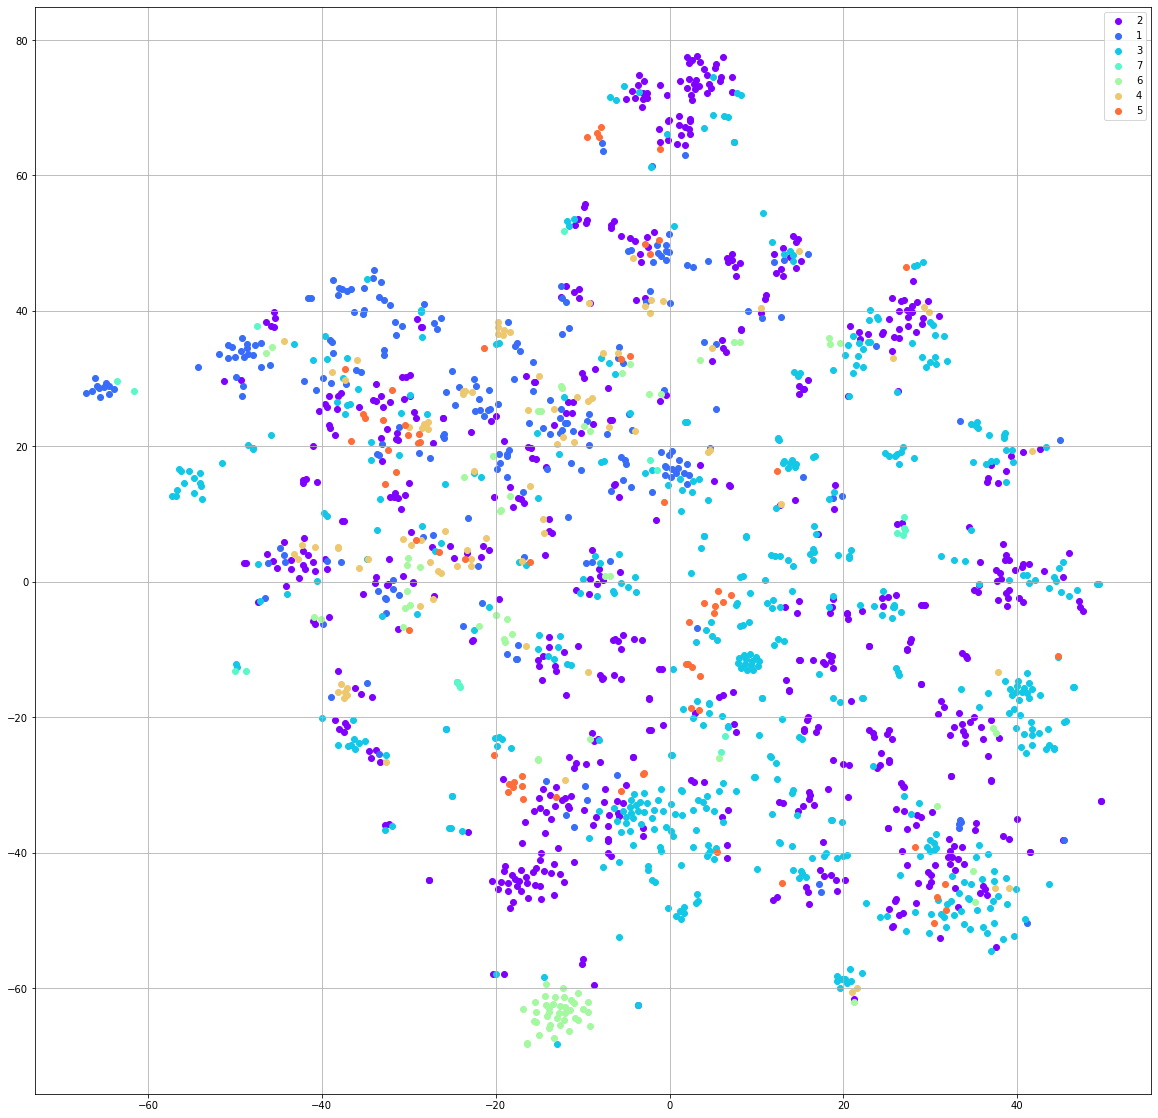

In [17]:
classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(XN[k, 0])
        classes[ec][1].append(XN[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)
plt.savefig('data/fig_dl2vec_node2vec.jpg')

plt.show()